<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/RFsim3d_double_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explantions

## 1. **Random Sampling (CPU)**:
The full list of all possible sampling in numpy can be found in the following [link](https://numpy.org/doc/1.16/reference/routines.random.html).
## 2. **GPU computation**:
GPU computation of the random field is given by [Cupy](https://cupy.dev/).

##  3. **Simulation of Gaussian Random Field**

  - Generate the (normal distributed) white noise field $\langle n(\vec x) n(\vec y) \rangle \propto \delta^3(\vec x, \vec y)$.

  - Perform Fast Fourier transform to obtain noise field of unit amplitude $\langle n(\vec k) n(-\vec k) \rangle = 1$

  - Obtain the fourier ampltide by multiplying the white noise field with the
 power spectrum:
$\langle \phi(\vec k)\phi(-\vec k)\rangle'=\langle n(\vec k) n(-\vec k) \rangle \times P(k)$ for $P(k) \equiv {A}{ \lvert k \rvert^{-d}}$.
  - Inverse Fast Fourier transform to obtain the gaussian field.

  - References: Gaussian Random Field is constructed out of [the following website](https://garrettgoon.com/gaussian-fields/).

### **Parameters for Field Simulation:**

- `amplitude`: amplitude of spectrum $A$
- `k_power` : power law of the spectrum $d$
- `pixel` : pixels, size of the plots
- `mean` : mean of the gaussian distribution
- `std_dev` : standard deviation of the gaussian distribution
- `decay_rate` : decay rate of the exponential distribution
- `expected_occurrences_rate ` : expected occurrences rate of the poisson distribution

## 4. **Clustering Algorithm**
### 4.1 **Density-based spatial clustering of applications with noise (DBSCAN)**:
  This algorithm defines clusters as continuous regions of high density.
  - For each instance, the algorithm counts the number of instances within a small distance ϵ (*epsilon*). This region is called the instance’s ϵ-neighborhood.
  - If an instance has at least min_samples instances within its ϵ-neighborhood (includingitself), then it is considered a core instance. Core instances are those that are located in dense regions.
  - All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
  - Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

### **Parameters**
  - `eps` : distance parameter $ϵ$
  - `min_samples` : Minimum amount of instasnces required in a $ϵ$ neighborhood
  - `Cluster -1` : Instances that are not a core instance. Marked in black color.




In [1]:
# @title Import packages

#import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import psutil

from scipy.special import erf

# 1. Define functions

In [2]:

# @title 1.2 Random field simulations

def get_process_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Return memory usage in MB

def grf_3d_32f(mean, std_dev, pixel, z_pixel, amplitude, k_power):
    # 3D Fast Fourier transform of the white noise
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel, z_pixel)).astype(np.float32)
    print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
    print(f"Total memory usage: {get_process_memory():.2f} MB")

    fft_white_noise = np.fft.fftn(white_noise).astype(np.complex64)
    del white_noise
    gc.collect()
    print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
    print(f"Total memory usage: {get_process_memory():.2f} MB")

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel)*pixel
    ky = np.fft.fftfreq(pixel)*pixel
    kz = np.fft.fftfreq(z_pixel)*z_pixel

    kx_grid, ky_grid, kz_grid = np.meshgrid(kx.astype(np.float32), ky.astype(np.float32), kz.astype(np.float32),sparse = True)
    del kx, ky, kz
    gc.collect()
    # Genearting FFT momentum 3D array
    # Norm of k

    k_norm = np.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2).astype(np.float32)
    k_norm[0][0][0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid, kz_grid
    gc.collect()
    print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
    print(f"Total memory usage: {get_process_memory():.2f} MB")

    # Power Spectrum P_k
    power_spectrum = (amplitude*(((2*np.pi/pixel)*k_norm)**(-1*k_power))).astype(np.complex64)  # P(k)=amplitude/k^{power},
    del k_norm
    gc.collect()
    print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
    print(f"Total memory usage: {get_process_memory():.2f} MB")

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt =  np.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
    del power_spectrum, fft_white_noise
    gc.collect()
    print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
    print(f"Total memory usage: {get_process_memory():.2f} MB")

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt
    gc.collect()
    print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
    print(f"Total memory usage: {get_process_memory():.2f} MB")


    return gaussian_random_field


def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)

In [33]:
# @title 1.3 Plots figures

def statistic_overview(exprf, n_sigma):

    all_points_3d = exprf.flatten()
    exprf_std_3d = np.std(all_points_3d)
    exprf_mean_3d = np.mean(all_points_3d)
    cutoff_3d = exprf_mean_3d + n_sigma*exprf_std_3d

    plt.style.use('seaborn-darkgrid')
    #print(f'Standard deviation = {exprf_std_3d:.2f}')
    #print(f'Mean = {exprf_mean_3d:.2f}')
    #print(f'Cutoff = {cutoff_3d:.2f}, i.e. {n_sigma} Sigmas from the mean at {exprf_mean_3d:.2f}')

    plt.hist(all_points_3d, bins=100);
    plt.yscale('log')
    plt.xlabel('Field amplitude', fontsize=12)
    plt.ylabel('Number of data points (Log)', fontsize=12)
    plt.axvline(x=cutoff_3d, color='r', linestyle='-', label='Cutoff amplitude')

    # Add text to the plot
    textstr = f'Std. Dev. = {exprf_std_3d:.2f}\nMean = {exprf_mean_3d:.2f}\nCutoff = {cutoff_3d:.2f} ({n_sigma} Std. Dev. from mean)'
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10
            , verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.title('Random Field Statistics', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    del all_points_3d
    gc.collect()
    # Save the plot with text
    plt.savefig(f'Statistic_info_Threshold_at_{cutoff_3d}.pdf')
    plt.show()

    return cutoff_3d, exprf_std_3d, exprf_mean_3d


def submanifolds(grf, masked_positions, l, pixel, z_pixel):

    sub_manifolds_list={}
    total_mass={}

    for ii in range(masked_positions.shape[0]):
        x, y, z = masked_positions[ii]
        x_min, x_max = max(x-l,0), min(x+l +1, pixel)
        y_min, y_max = max(y-l,0), min(y+l +1, pixel)
        z_min, z_max = max(z-l,0), min(z+l +1, z_pixel)

        sub_grf = grf[x_min:x_max, y_min:y_max, z_min:z_max]
        sub_manifolds_list[ii] = sub_grf
        total_mass[ii] = np.sum(sub_grf)

        np.save(f'sub_manifolds_list.npy', sub_manifolds_list )
        np.save(f'total_amplitude.npy', total_mass)

    return sub_manifolds_list, total_mass

# 2. **Main**

In [28]:
# @title Parameters
amplitude = 1 # amplitude of the power spectrum
k_power = 3 # power of k in the power spectrum

# Define the size of the square grid
pixel = 2**8  # 2^8 = 256
z_pixel = pixel # Reduce ram usage
#chunk_size = 2**8

# Parameters for the normal distribution
mean = 0      # Mean
std_dev = 1   # Standard deviation
# Parameters for exponential decay
decay_rate = 1
# Paratmer for cut-off
cutoff_sigma = 19-6
# 6-sigma of Gaussian(2*10E-9) ~ 19-sigmas of Exponential(2.1*10E-9)
# Using 12 Sigma for testing

## 2.2 3D Model

white_noise allocates: 64.00 MB of memory.
Total memory usage: 220.75 MB
fft_white_noise allocates: 128.00 MB of memory.
Total memory usage: 284.75 MB
k_norm allocates: 64.00 MB of memory
Total memory usage: 348.75 MB
power_spectrum allocates: 128.00 MB of memory
Total memory usage: 412.75 MB
fourier_amplitudes_sqrt allocates: 128.00 MB of memory
Total memory usage: 284.75 MB
gaussian_random_field allocates: 128.00 MB of memory
Total memory usage: 412.75 MB


<ipython-input-3-48a57f561544>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


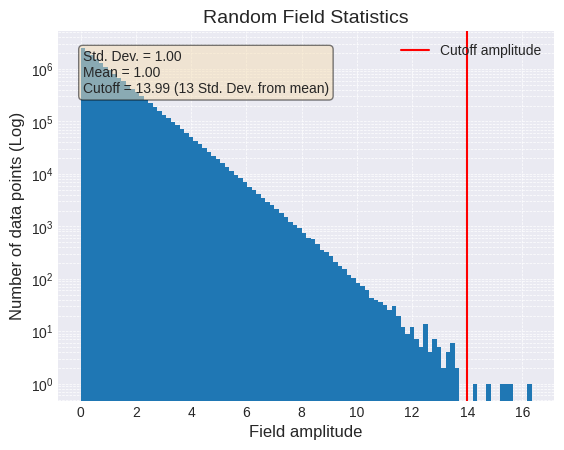

<ipython-input-3-48a57f561544>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


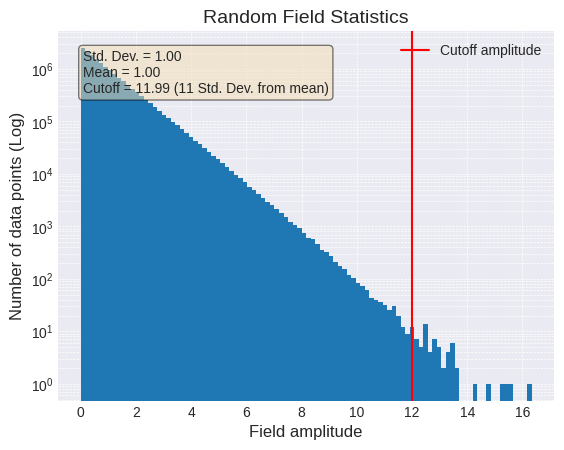

0

In [7]:
# @title Run 3D Model

# Run 3D Model (GPU)
#grf  = gpu_grf_3d(gaussian_white_noise_3d(pixel, z_pixel, mean, std_dev), pixel, z_pixel, amplitude, k_power)

## Work flow

# Run 3D Model (CPU)
grf = grf_3d_32f( mean, std_dev, pixel, z_pixel, amplitude, k_power)

# 1. Convert to exponential distribution
exprf = gaussian_to_exp(grf, decay_rate)

# 2. Delete Gaussiqn Field and summon trash can
del grf
gc.collect()

# 3. Save the exponential field to npy format
np.save('exponential_field.npy', exprf)

# 4. Save the field statistic to pdf format, return threshold values
cutoff_3d, exprf_std_3d, exprf_mean_3d = statistic_overview(exprf, cutoff_sigma)

# 5. Save mask and positions where amplitude exceed threshold
mask = np.abs(exprf) > cutoff_3d
np.save('mask.npy', mask)
positions = np.argwhere(mask)
np.save('mask_positions.npy', positions)

# 6. Delete outputs and summon trash can

less_sigma_cutoff_3d, a1, a2 = statistic_overview(exprf, cutoff_sigma - 2)
del a1, a2
gc.collect()

# 7.  Save mask and positions where amplitude exceed threshold - 1 sigma
less_sigma_mask = np.abs(exprf) > less_sigma_cutoff_3d
np.save('less_sigma_mask.npy', less_sigma_mask)
less_sigma_positions = np.argwhere(less_sigma_mask)
np.save('less_sigma_mask_positions.npy', less_sigma_positions)

sub_manifolds_list, total_mass = submanifolds(exprf, positions, 2, pixel, z_pixel)
# 8. Delete outputs and summon trash can
del exprf, less_sigma_mask, less_sigma_positions, mask, positions
gc.collect()

for ii in range(positions.shape[0]):
    plt.hist(sub_manifolds_list[ii].flatten(),bins=100);

print(total_mass)